# Siamese Network on template ligand-docking dataset

In [1]:
!nvidia-smi

Sat Mar 12 12:29:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   60C    P2    67W / 240W |    724MiB /  8116MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#%%capture
#!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
#!chmod +x Miniconda3-latest-Linux-x86_64.sh
#!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
#!time conda install -q -y -c conda-forge rdkit

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [6]:
dataset = 'oldsmiledata_id_processed_transformed_shuffled'

In [7]:
path = Path('../dataset/oldsmiledata')

In [8]:
list(path.iterdir())

[PosixPath('../dataset/oldsmiledata/test_oldsmiledata_id_processed_transformed_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/train_balanced_oldsmiledata_id_processed_transformed_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/oldsmiledata_id_processed_transformed_rescaled_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/.ipynb_checkpoints'),
 PosixPath('../dataset/oldsmiledata/mol_images'),
 PosixPath('../dataset/oldsmiledata/valid_balanced_oldsmiledata_id_processed_transformed_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/train_oldsmiledata_id_processed_transformed_shuffled.csv')]

In [9]:
#IMAGES = path/'mol_images'/'all'
train = pd.read_csv(path/f'train_balanced_{dataset}.csv', index_col=0)
valid = pd.read_csv(path/f'valid_balanced_{dataset}.csv', index_col=0)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19139 entries, 0 to 19138
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        19139 non-null  object 
 1   docked                          19139 non-null  object 
 2   rmsd                            19139 non-null  float64
 3   uniprot_id                      19139 non-null  object 
 4   smiles_template                 19139 non-null  object 
 5   smiles_docked                   19139 non-null  object 
 6   mcs_smartsString                19139 non-null  object 
 7   template_HeavyAtomCount         19139 non-null  int64  
 8   template_NHOHCount              19139 non-null  int64  
 9   template_NOCount                19139 non-null  int64  
 10  template_RingCount              19139 non-null  int64  
 11  template_NumHAcceptors          19139 non-null  int64  
 12  template_NumHDonors             

In [11]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4785 entries, 0 to 4784
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        4785 non-null   object 
 1   docked                          4785 non-null   object 
 2   rmsd                            4785 non-null   float64
 3   uniprot_id                      4785 non-null   object 
 4   smiles_template                 4785 non-null   object 
 5   smiles_docked                   4785 non-null   object 
 6   mcs_smartsString                4785 non-null   object 
 7   template_HeavyAtomCount         4785 non-null   int64  
 8   template_NHOHCount              4785 non-null   int64  
 9   template_NOCount                4785 non-null   int64  
 10  template_RingCount              4785 non-null   int64  
 11  template_NumHAcceptors          4785 non-null   int64  
 12  template_NumHDonors             47

In [12]:
train.head()

,template,docked,rmsd,uniprot_id,smiles_template,smiles_docked,mcs_smartsString,template_HeavyAtomCount,template_NHOHCount,template_NOCount,...,mcs_docked_NumHDonors,mcs_template_NumRotatableBonds,mcs_docked_NumRotatableBonds,ec_tanimoto_similarity,fc_tanimoto_similarity,log_RMSD,bin_RMSD,Xtransf_ec_tanimoto_similarity,Xtransf_fc_tanimoto_similarity,is_valid
0,1YPJ_UIB,1K22_MEL,4.643,P00734,CC[C@@H]1[C@@H]2[C@H](C(=O)N1Cc1ccc3c(c1)OCO3)...,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,[#7]=[#6](-[#7])-[#6]1:[#6]:[#6]:[#6](:[#6]:[#...,33,3,7,...,3,4,7,0.165775,0.289941,1.535361,3,-0.342246,-0.100592,False
1,2JH5_895,1C5O_BAM,3.209,P00734,C[C@@H](C(=O)N1CCOCC1)N1CC[C@H](NS(=O)(=O)/C=C...,NC(=[NH2+])c1ccccc1,"[#7]-[#6]-[#6]:,-[#6]:,-[#6]",28,1,8,...,1,0,1,0.050847,0.059829,1.165959,3,-1.491525,-2.401709,False
2,5Y12_8JX,1TOW_CRZ,1.769,P15090,COc1ccc(S(=O)(=O)NCCCCC(=O)O)c2ccccc12,O=C(O)CCCn1c2ccccc2c2ccccc21,[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1:[#6]:[#6]:[#6...,23,2,6,...,0,0,0,0.324561,0.324561,0.570414,1,1.245614,0.245614,False
3,1C1U_BAI,5AHG_Y4L,3.943,P00734,N=C(N)c1ccc2[nH]c(Cc3nc4ccccc4[nH]3)nc2c1,CN(C)S(=O)(=O)Nc1ccc(Cl)cc1,"[#7]-,:[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1",22,5,6,...,1,0,1,0.086957,0.106195,1.371942,3,-1.130435,-1.938053,False
4,2W26_RIV,2Y80_439,7.217,P00742,O=C(NC[C@H]1CN(c2ccc(N3CCOCC3=O)cc2)C(=O)O1)c1...,CN(C)[C@@H]1CCc2cc(N3CC[C@H](NS(=O)(=O)c4ccc5c...,[#7]-[#6]-[#6]-[#6]-[#7](-[#6]1:[#6]:[#6]:[#6]...,29,1,8,...,1,3,2,0.187166,0.283237,1.976439,3,-0.128342,-0.167630,False


# Preprocessing

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

### Splitting the data into train and validation sets

In [14]:
train['img_temp'] = train['template'] + '.png'
train['img_docked'] = train['docked'] + '.png'
train['is_valid'] = False
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19139 entries, 0 to 19138
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        19139 non-null  object 
 1   docked                          19139 non-null  object 
 2   rmsd                            19139 non-null  float64
 3   uniprot_id                      19139 non-null  object 
 4   smiles_template                 19139 non-null  object 
 5   smiles_docked                   19139 non-null  object 
 6   mcs_smartsString                19139 non-null  object 
 7   template_HeavyAtomCount         19139 non-null  int64  
 8   template_NHOHCount              19139 non-null  int64  
 9   template_NOCount                19139 non-null  int64  
 10  template_RingCount              19139 non-null  int64  
 11  template_NumHAcceptors          19139 non-null  int64  
 12  template_NumHDonors             

In [15]:
valid['img_temp'] = valid['template'] + '.png'
valid['img_docked'] = valid['docked'] + '.png'
valid['is_valid'] = True
valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4785 entries, 0 to 4784
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        4785 non-null   object 
 1   docked                          4785 non-null   object 
 2   rmsd                            4785 non-null   float64
 3   uniprot_id                      4785 non-null   object 
 4   smiles_template                 4785 non-null   object 
 5   smiles_docked                   4785 non-null   object 
 6   mcs_smartsString                4785 non-null   object 
 7   template_HeavyAtomCount         4785 non-null   int64  
 8   template_NHOHCount              4785 non-null   int64  
 9   template_NOCount                4785 non-null   int64  
 10  template_RingCount              4785 non-null   int64  
 11  template_NumHAcceptors          4785 non-null   int64  
 12  template_NumHDonors             47

In [16]:
# image size 600,600
target_shape=(600, 600)

## Creating postive and negative datasets 

In [17]:
train_good = train[train.log_RMSD <= 1.5]
train_good = train_good.reset_index(drop=True)
train_good.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7926 entries, 0 to 7925
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        7926 non-null   object 
 1   docked                          7926 non-null   object 
 2   rmsd                            7926 non-null   float64
 3   uniprot_id                      7926 non-null   object 
 4   smiles_template                 7926 non-null   object 
 5   smiles_docked                   7926 non-null   object 
 6   mcs_smartsString                7926 non-null   object 
 7   template_HeavyAtomCount         7926 non-null   int64  
 8   template_NHOHCount              7926 non-null   int64  
 9   template_NOCount                7926 non-null   int64  
 10  template_RingCount              7926 non-null   int64  
 11  template_NumHAcceptors          7926 non-null   int64  
 12  template_NumHDonors             79

In [18]:
negative = train[train.log_RMSD > 2.1]
negative = negative.reset_index(drop=True)
len(negative)

4898

In [19]:
valid_good = valid[valid.log_RMSD <= 1.5]
valid_good = valid_good.reset_index(drop=True)
len(valid_good)

2045

In [20]:
val_negative = valid[valid.log_RMSD > 2]
val_negative = val_negative.reset_index(drop=True)
len(val_negative)

1548

In [21]:
IMAGES = '../dataset/oldsmiledata/mol_images/poseview_envs/'

In [22]:
def preprocess_image(filename):
    img_str = tf.io.read_file(IMAGES + filename)
    image = tf.image.decode_png(img_str, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    #image = tf.transpose(image)
    return image

In [23]:
%%capture
#img_shape = preprocess_image(train.img_temp[0]).shape

In [24]:
#img_shape

In [25]:
!nvidia-smi

Sat Mar 12 12:29:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   60C    P2    67W / 240W |    729MiB /  8116MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [26]:
physical_device = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_device[0], True)

In [27]:
def preprocess_triplets(template, docked, negative, rmsd):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (preprocess_image(template), preprocess_image(docked), preprocess_image(negative), rmsd)
    

In [28]:
def preprocess_triplets_2(tup, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (preprocess_image(tup[0]),
        preprocess_image(tup[1]),
        preprocess_image(negative))

In [29]:
#image = preprocess_image('/4A7I_A7I.png')
#image.shape

In [30]:
train_template_images = [r.img_temp for i, r in train_good.iterrows()]

In [31]:
train_docked_images = [r.img_docked for i, r in train_good.iterrows()]

In [32]:
len(train_template_images), len(train_docked_images)

(7926, 7926)

In [33]:
def find_negative_train(docked):
    negs = negative[negative.docked == docked]
    negs = negs.reset_index(drop=True)
    if len(negs) > 0:
        i = random.randint(0,len(negs) - 1)
        neg = negs.iloc[i]
    else:
        i = random.randint(0,len(negative) - 1)
        neg = negative.iloc[i]
    return neg.img_docked

In [34]:
def find_negative_val(docked):
    negs = val_negative[val_negative.docked == docked]
    negs = negs.reset_index(drop=True)
    if len(negs) > 0:
        i = random.randint(0,len(negs) - 1)
        neg = negs.iloc[i]
    else:
        i = random.randint(0,len(val_negative) - 1)
        neg = val_negative.iloc[i]
    return neg.img_docked

In [35]:
n = find_negative_train(train.iloc[0].docked)
n

'1K22_MEL.png'

In [36]:
valid_template_images = [r.img_temp for i, r in valid_good.iterrows()]
valid_docked_images = [r.img_docked for i, r in valid_good.iterrows()]

In [37]:
import tensorflow as tf
print('Num GPus avalable: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPus avalable:  1


In [38]:
negative_images = [find_negative_train(r.docked) for i, r in train_good.iterrows()]
#np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
#negative_dataset = negative_dataset.shuffle(buffer_size=4096)

In [39]:
val_negative_images = [find_negative_val(r.docked) for i, r in valid_good.iterrows()]
#np.random.RandomState(seed=32).shuffle(negative_images)

val_negative_dataset = tf.data.Dataset.from_tensor_slices(val_negative_images)
#val_negative_dataset = val_negative_dataset.shuffle(buffer_size=4096)

In [40]:
image_count = len(train_template_images) + len(valid_template_images)
image_count

9971

In [41]:
neg_image_count = len(negative_images) + len(val_negative_images)
neg_image_count

9971

In [42]:
template_dataset = tf.data.Dataset.from_tensor_slices(train_template_images)
docked_dataset = tf.data.Dataset.from_tensor_slices(train_docked_images)

In [43]:
val_template_dataset = tf.data.Dataset.from_tensor_slices(valid_template_images)
val_docked_dataset = tf.data.Dataset.from_tensor_slices(valid_docked_images)

In [44]:
y_train = train_good['log_RMSD']
y_train = tf.data.Dataset.from_tensor_slices(list(y_train))


In [45]:
y_valid = valid_good['log_RMSD']
y_valid = tf.data.Dataset.from_tensor_slices(list(y_train))

In [46]:
log_rmsd = [r.log_RMSD for i, r in train_good.iterrows()]
val_log_rmsd = [r.log_RMSD for i, r in valid_good.iterrows()]

In [47]:
log_rmsd_dataset = tf.data.Dataset.from_tensor_slices(log_rmsd)
val_log_rmsd_dataset = tf.data.Dataset.from_tensor_slices(val_log_rmsd)

In [48]:
!nvidia-smi

Sat Mar 12 12:29:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   62C    P2    68W / 240W |    949MiB /  8116MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Create the train and validation datasets

In [49]:
train_dataset = tf.data.Dataset.zip((docked_dataset, template_dataset, negative_dataset, log_rmsd_dataset)) # template as anchor
#train_dataset = tf.data.Dataset.zip((template_dataset, docked_dataset, negative_dataset)) # template as anchor
valid_dataset = tf.data.Dataset.zip((val_docked_dataset, val_template_dataset, val_negative_dataset, val_log_rmsd_dataset)) # template as anchor
#valid_dataset = tf.data.Dataset.zip((val_template_dataset, val_docked_dataset, val_negative_dataset)) # template as anchor
train_dataset, valid_dataset

(<ZipDataset shapes: ((), (), (), ()), types: (tf.string, tf.string, tf.string, tf.float32)>,
 <ZipDataset shapes: ((), (), (), ()), types: (tf.string, tf.string, tf.string, tf.float32)>)

In [50]:
train_dataset = train_dataset.take(round(image_count * 1))
train_dataset

<TakeDataset shapes: ((), (), (), ()), types: (tf.string, tf.string, tf.string, tf.float32)>

In [51]:
train_dataset = train_dataset.map(preprocess_triplets)
val_dataset = valid_dataset.map(preprocess_triplets)
train_dataset, val_dataset

(<MapDataset shapes: ((600, 600, 3), (600, 600, 3), (600, 600, 3), ()), types: (tf.float32, tf.float32, tf.float32, tf.float32)>,
 <MapDataset shapes: ((600, 600, 3), (600, 600, 3), (600, 600, 3), ()), types: (tf.float32, tf.float32, tf.float32, tf.float32)>)

In [52]:
train_dl = train_dataset.batch(8, drop_remainder=True)
train_dl = train_dl.prefetch(8)
train_dl

<PrefetchDataset shapes: ((8, 600, 600, 3), (8, 600, 600, 3), (8, 600, 600, 3), (8,)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

In [53]:
val_dl = val_dataset.batch(8, drop_remainder=True)
val_dl = val_dl.prefetch(8)
val_dl

<PrefetchDataset shapes: ((8, 600, 600, 3), (8, 600, 600, 3), (8, 600, 600, 3), (8,)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

## Anchor, positive and the distance between them computed by the distance layer

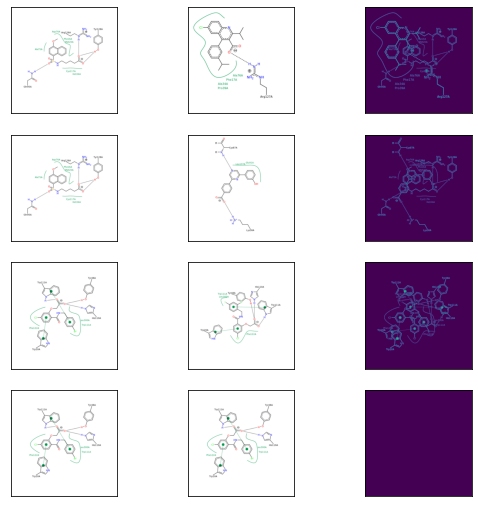

In [54]:
def visualize(anchor, positive, negative, rmsd):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(4, 3)
    for i in range(0, 4, 2):
        show(axs[i, 0], anchor[i])
        show(axs[i + 1, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i + 1, 1], negative[i])
        ap_distance = tf.reduce_sum(tf.square(anchor[i] - positive[i]), -1)
        an_distance = tf.reduce_sum(tf.square(anchor[i] - negative[i]), -1)
        show(axs[i, 2], ap_distance)
        show(axs[i + 1, 2], an_distance)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss, 0.0)
    


visualize(*list(val_dl.take(1).as_numpy_iterator())[0])

## Visualization of Anchor, Positive and the Negative image

1.3045418
0.61572605
-0.19845094


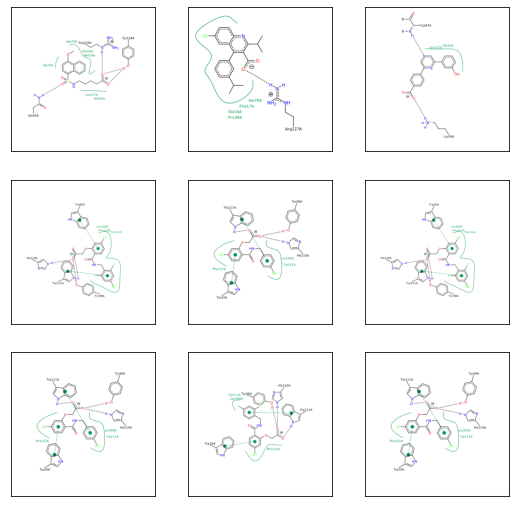

In [55]:
def visualize2(anchor, positive, negative, rmsd):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        print(rmsd[i])
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize2(*list(val_dl.take(1).as_numpy_iterator())[0])

In [56]:
def visualize_positive(anchor, positive):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(1, 2))

    axs = fig.subplots(1, 2)
    show(axs[0, 0], anchor)
    show(axs[0, 1], positive)

# Siamese network with distance layer and RMSD as adaptive margin in loss function

### Use RMSD as an adaptive margin in loss function

In [57]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape +  (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(256, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(128)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable


In [58]:
!nvidia-smi

Sat Mar 12 12:29:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 28%   63C    P2    68W / 240W |   5174MiB /  8116MiB |     14%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [59]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative, rmsd):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance, rmsd)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))
rmsd_input = layers.Input(name='rmsd', shape=(1))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
    rmsd_input,
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input, rmsd_input], outputs=distances
)

siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
negative (InputLayer)           [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 600, 600, 3)  0           anchor[0][0]                     
______________________________________________________________________________________________

### Triplet loss defined as: 

$$\displaystyle {\mathcal {L}}\left(A,P,N\right)=\operatorname {max} \left({\|\operatorname {f} \left(A\right)-\operatorname {f} \left(P\right)\|}^{2}-{\|\operatorname {f} \left(A\right)-\operatorname {f} \left(N\right)\|}^{2}+\alpha ,0\right)$$

In [60]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=2):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")
        self.rmse_tracker = metrics.RootMeanSquaredError(name="rmse")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        ap_distance, an_distance, rmsd = self.siamese_network(data)
        # Let's update and return the loss metric and rmse metric.
        self.loss_tracker.update_state(loss)
        distance = ap_distance - an_distance
        # RMSE (Euclidean distance) between anchor and positive image minus RMSD
        rmse = tf.maximum(distance, 0.0)
        self.rmse_tracker.update_state(0.0, rmse)
        return {"loss": self.loss_tracker.result(), 'rmse': self.rmse_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance, rmsd = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin - rmsd, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.rmse_tracker]


### Choose optimizer and train model

In [61]:
physical_device = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_device[0], True)
print("GPUS available", len(physical_device))

GPUS available 1


In [62]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001), metrics=metrics.RootMeanSquaredError(name='rmse'))

In [63]:
!nvidia-smi

Sat Mar 12 12:29:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 27%   60C    P2    52W / 240W |   5174MiB /  8116MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [64]:
model_history = siamese_model.fit(train_dl, validation_data=val_dl, epochs=5) # save

Epoch 1/5
990/990 [==============================] - 771s 759ms/step - loss: 1.5789 - val_loss: 1.1333 - val_rmse: 0.2202
Epoch 2/5
990/990 [==============================] - 946s 955ms/step - loss: 1.1479 - val_loss: 1.0515 - val_rmse: 0.2197
Epoch 3/5
990/990 [==============================] - 796s 804ms/step - loss: 1.0732 - val_loss: 0.9783 - val_rmse: 0.2004
Epoch 4/5
990/990 [==============================] - 797s 806ms/step - loss: 1.0458 - val_loss: 0.9470 - val_rmse: 0.1608
Epoch 5/5
990/990 [==============================] - 800s 808ms/step - loss: 1.0077 - val_loss: 0.9233 - val_rmse: 0.1361


In [65]:
model_history = siamese_model.fit(train_dl, validation_data=val_dl, epochs=5) # save

Epoch 1/5
990/990 [==============================] - 779s 787ms/step - loss: 0.9986 - val_loss: 0.9190 - val_rmse: 0.1296
Epoch 2/5
990/990 [==============================] - 713s 720ms/step - loss: 0.9901 - val_loss: 0.9078 - val_rmse: 0.1427
Epoch 3/5
990/990 [==============================] - 720s 728ms/step - loss: 0.9881 - val_loss: 0.9036 - val_rmse: 0.1369
Epoch 4/5
990/990 [==============================] - 770s 778ms/step - loss: 0.9697 - val_loss: 0.8894 - val_rmse: 0.1518
Epoch 5/5
990/990 [==============================] - 720s 728ms/step - loss: 0.9622 - val_loss: 0.8899 - val_rmse: 0.1370


### RMSE as difference between rmsd and ap - an distances

In [66]:
model_history = siamese_model.fit(train_dl, validation_data=val_dl, epochs=2)

Epoch 1/2
241/990 [======>.......................] - ETA: 6:36 - loss: 0.9738

KeyboardInterrupt: 

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Inspecting what the network has learned

tf.Tensor(1.3045418, shape=(), dtype=float32)
tf.Tensor(0.61572605, shape=(), dtype=float32)
tf.Tensor(-0.19845094, shape=(), dtype=float32)


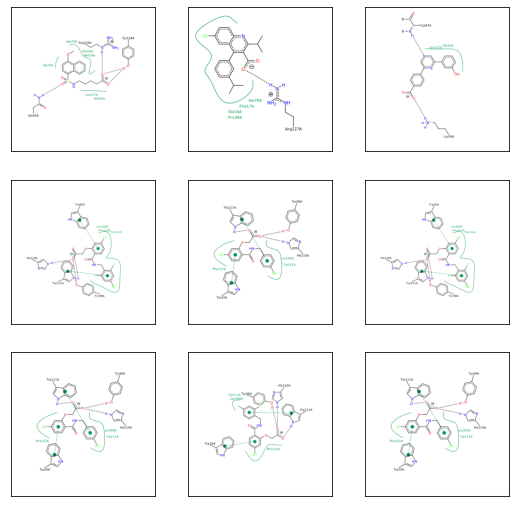

In [67]:
sample = next(iter(val_dl))
visualize2(*sample)

anchor, positive, negative, _ = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [68]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


Positive similarity: 0.99965966
Negative similarity 0.9945868


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import os, sys, cv2, matplotlib.pyplot as plt, numpy as np, pickle
#import sklearn, pandas as pd, seaborn as sn
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Load models
#model = embedding
model = siamese_model

names = next(iter(val_dl))

anchor, positive, negative, rmsd = names
anchor = tf.reshape(anchor[0], (1, 224, 224, 3))
positive = tf.reshape(positive[0], (1, 224, 224, 3))
negative = tf.reshape(negative[0], (1, 224, 224, 3))
rmsd = tf.reshape(rmsd[0], (1, 1))


test_im = []
test_im.append(anchor)
test_im.append(positive)
test_im.append(negative)

print(test_im[0].shape)
_, r,c,_ = test_im[0].shape
print(test_im[0].shape)
test_im = np.array(test_im)
test_im = test_im.reshape((len(test_im), r,c,3))

test_im = 1 - test_im/255

# Predict
pred = model.predict([anchor, positive, negative, rmsd])

print(pred)

num = int(pred.shape[0]/3)
colors = ['red', 'blue', 'green'] # set colors of target labels

# Set target labels
y = [colors[0] for i in range(num)]
y += [colors[1] for i in range(num)]
y += [colors[2] for i in range(num)]

feat1 = pred[:,0]
feat2 = pred[:,1]
feat3 = pred[:,2]

# Plot 3d scatter plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(feat1, feat2, feat3, c=y, marker='.')
plt.show()

# Parameter optimization 

In [ ]:
def create_embedding(dropout = None):
    base_cnn = resnet.ResNet50(
        weights="imagenet", input_shape=target_shape +  (3,), include_top=False
    )

    flatten = layers.Flatten()(base_cnn.output)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    if dropout != None: 
        layer = layers.Dropout(dropout)
    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(256)(dense2)

    embedding = Model(base_cnn.input, output, name="Embedding")

    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable
    return embedding

In [ ]:
def create_siamese_net(embedding):
    anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
    positive_input = layers.Input(name="positive", shape=target_shape + (3,))
    negative_input = layers.Input(name="negative", shape=target_shape + (3,))

    distances = DistanceLayer()(
        embedding(resnet.preprocess_input(anchor_input)),
        embedding(resnet.preprocess_input(positive_input)),
        embedding(resnet.preprocess_input(negative_input)),
    )

    siamese_network = Model(
        inputs=[anchor_input, positive_input, negative_input], outputs=distances
    )

    return siamese_network

In [ ]:
def train_model(epochs = 5, lr=0.0001, dropout=None, verbose=False):
    embedding = create_embedding(dropout=dropout)
    siamese_network = create_siamese_net(embedding)
    siamese_model = SiameseModel(siamese_network)
    siamese_model.compile(optimizer=optimizers.Adam(learning_rate=lr), metrics=[metrics.RootMeanSquaredError(name='rmse')])
    model = siamese_model.fit(train_dl, validation_data=val_dl, epochs=epochs)
    if verbose:
        plt.plot(model.history['loss'])
        plt.plot(model.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        plt.plot(model.history['val_rmse'])
        plt.title('model RMSE')
        plt.ylabel('RMSE')
        plt.xlabel('epoch')
        plt.legend(['rmse'], loc='upper left')
        plt.show()
    return siamese_model
        
    

# Save the model

In [69]:
from tensorflow.keras import models

In [70]:
siamese_model.compute_output_shape(input_shape= [(None, 600, 600, 3), (None, 600, 600, 3), (None, 600, 600, 3), (None, 1)])                        

(TensorShape([None]), TensorShape([None]), TensorShape([None, 1]))

In [71]:
siamese_model.save('models/siamese_model_envs')

INFO:tensorflow:Assets written to: models/siamese_model_envs/assets


In [72]:
model = models.load_model('models/siamese_model_envs')

# Test the model performance on instances

In [102]:
test = pd.read_csv(path/'test_oldsmiledata_id_processed_transformed_shuffled.csv')

In [103]:
test['img_temp'] = test['template'] + '.png'
test['img_docked'] = test['docked'] + '.png'

In [73]:
sample = next(iter(val_dl))

In [104]:
docked_sample = test.iloc[0]
docked_sample.docked

'3SHC_B01'

In [105]:
docked_image = preprocess_image(docked_sample.img_docked)

In [1]:
df = pd.concat([valid, test])

NameError: name 'pd' is not defined

### Sort the templates for one docked molecule by order of lowest rmsd

In [114]:
templates = df[df.docked == docked_sample.docked]
templates = templates.reset_index(drop=True)
templates = templates.sort_values(by=['rmsd'], ignore_index=True)
len(templates.template.unique())

91

In [109]:
template_image = preprocess_image(templates.iloc[0].img_temp)

Show docked molecule


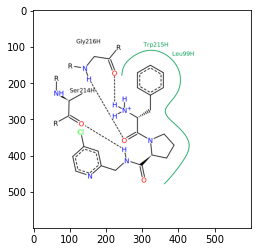

In [110]:
print('Show docked molecule')
plt.imshow(docked_image)

Show lowest rmsd template molecule


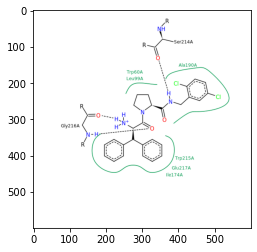

In [111]:
print('Show lowest rmsd template molecule')
plt.imshow(template_image)

In [112]:
rmsds = templates.log_RMSD
rmsds

0    -1.589635
1    -0.991553
2    -0.918794
3    -0.874669
4    -0.424648
        ...   
86    2.334859
87    2.361797
88    2.455649
89    2.479056
90    2.497329
Name: log_RMSD, Length: 91, dtype: float64

In [115]:
# Root Mean Squared Error
rmse = metrics.RootMeanSquaredError()

In [116]:
# Similarity search
similarity = metrics.CosineSimilarity()

In [117]:
tf_template = tf.reshape(template_image, (1,600,600,3))

In [118]:
tf_docked = tf.reshape(docked_image, (1,600,600,3))

In [119]:
template_embedding, docked_embedding = (
    embedding(resnet.preprocess_input(tf_template)),
    embedding(resnet.preprocess_input(tf_docked)),
)

In [120]:
rmse_positive = rmse(template_embedding, docked_embedding)
rmse_positive.numpy(), templates.iloc[0].log_RMSD

(0.020676631, -1.58963528513792)

In [121]:
type(rmse_positive.numpy())

numpy.float32

In [122]:
def get_rmse(row):
    # Checks the embedding space for two inputs and return the rmse
    docked_image = preprocess_image(row.img_docked)
    template_image = preprocess_image(row.img_temp)
    template_image = tf.reshape(template_image, (1,600,600,3))
    docked_image = tf.reshape(docked_image, (1,600,600,3))
    template_embedding, docked_embedding = (
        embedding(resnet.preprocess_input(template_image)),
        embedding(resnet.preprocess_input(docked_image)),
    )
    rmse_positive = rmse(template_embedding, docked_embedding)
    return rmse_positive.numpy()

In [123]:
def get_similarity(row):
    # Checks the embedding space for two inputs and return the rmse
    docked_image = preprocess_image(row.img_docked)
    template_image = preprocess_image(row.img_temp)
    template_image = tf.reshape(template_image, (1,600,600,3))
    docked_image = tf.reshape(docked_image, (1,600,600,3))
    template_embedding, docked_embedding = (
        embedding(resnet.preprocess_input(template_image)),
        embedding(resnet.preprocess_input(docked_image)),
    )
    similarity_positive = similarity(template_embedding, docked_embedding)
    return similarity_positive.numpy()

### Order ranked by rmse

In [124]:
rmses = {}
for i, r in templates.iterrows(): 
    rm = get_rmse(r)
    rmses[i] = rm
rmses

{0: 0.020676631,
 1: 0.018116765,
 2: 0.015873702,
 3: 0.01435258,
 4: 0.014405039,
 5: 0.014275944,
 6: 0.014698793,
 7: 0.014273472,
 8: 0.014148322,
 9: 0.013582803,
 10: 0.014079206,
 11: 0.013588307,
 12: 0.015002515,
 13: 0.015635999,
 14: 0.017401524,
 15: 0.01769087,
 16: 0.017953146,
 17: 0.017603386,
 18: 0.018236358,
 19: 0.017913835,
 20: 0.01766796,
 21: 0.017882394,
 22: 0.01792488,
 23: 0.018261807,
 24: 0.017926745,
 25: 0.017920211,
 26: 0.018616915,
 27: 0.018751942,
 28: 0.019271476,
 29: 0.019390408,
 30: 0.020224823,
 31: 0.02016211,
 32: 0.020193277,
 33: 0.022045022,
 34: 0.022292346,
 35: 0.022543274,
 36: 0.022930736,
 37: 0.02283844,
 38: 0.022627918,
 39: 0.022505963,
 40: 0.023232272,
 41: 0.023144266,
 42: 0.022942374,
 43: 0.023036024,
 44: 0.02291237,
 45: 0.023106346,
 46: 0.023050485,
 47: 0.022981962,
 48: 0.023593174,
 49: 0.023416799,
 50: 0.023673829,
 51: 0.02368385,
 52: 0.023544338,
 53: 0.023581406,
 54: 0.023410738,
 55: 0.02346913,
 56: 0.0233

In [125]:
similarities = {}
for i, r in templates.iterrows(): 
    sim = get_similarity(r)
    similarities[i] = sim
similarities

{0: 0.9996389,
 1: 0.99977714,
 2: 0.999844,
 3: 0.9998776,
 4: 0.9998659,
 5: 0.9998662,
 6: 0.99985284,
 7: 0.999861,
 8: 0.9998634,
 9: 0.99987525,
 10: 0.9998638,
 11: 0.9998739,
 12: 0.99984074,
 13: 0.9998256,
 14: 0.99978083,
 15: 0.99977475,
 16: 0.99976236,
 17: 0.99977165,
 18: 0.99975365,
 19: 0.99976236,
 20: 0.99976873,
 21: 0.99976194,
 22: 0.99976164,
 23: 0.9997539,
 24: 0.99976295,
 25: 0.9997636,
 26: 0.9997456,
 27: 0.99974114,
 28: 0.9997258,
 29: 0.9997222,
 30: 0.9996951,
 31: 0.99969584,
 32: 0.9996946,
 33: 0.9996293,
 34: 0.9996201,
 35: 0.9996102,
 36: 0.9995978,
 37: 0.99960184,
 38: 0.9996098,
 39: 0.99961406,
 40: 0.999588,
 41: 0.9995918,
 42: 0.99959874,
 43: 0.9995949,
 44: 0.99959964,
 45: 0.99959207,
 46: 0.99959433,
 47: 0.99959654,
 48: 0.9995747,
 49: 0.9995813,
 50: 0.99957293,
 51: 0.9995729,
 52: 0.9995778,
 53: 0.9995748,
 54: 0.99958134,
 55: 0.9995798,
 56: 0.9995854,
 57: 0.9995914,
 58: 0.9995891,
 59: 0.99959165,
 60: 0.9995409,
 61: 0.9995

### Order according to the model

In [126]:
sim_sorted = sorted(similarities, key=similarities.get, reverse=True)
sim_sorted

[3,
 9,
 11,
 5,
 4,
 10,
 8,
 7,
 6,
 2,
 12,
 13,
 14,
 1,
 15,
 17,
 20,
 25,
 24,
 16,
 19,
 21,
 22,
 23,
 18,
 26,
 27,
 28,
 29,
 31,
 30,
 32,
 0,
 33,
 34,
 39,
 35,
 38,
 37,
 44,
 42,
 36,
 47,
 43,
 46,
 45,
 41,
 59,
 57,
 58,
 40,
 56,
 54,
 49,
 55,
 52,
 53,
 48,
 50,
 51,
 66,
 63,
 64,
 62,
 67,
 65,
 68,
 61,
 72,
 74,
 73,
 71,
 60,
 69,
 70,
 76,
 75,
 79,
 80,
 78,
 77,
 83,
 82,
 81,
 84,
 88,
 86,
 89,
 87,
 90,
 85]

In [127]:
rmses_sorted = sorted(rmses, key=rmses.get)
rmses_sorted

[9,
 11,
 10,
 8,
 7,
 5,
 3,
 4,
 6,
 12,
 13,
 2,
 14,
 17,
 20,
 15,
 21,
 19,
 25,
 22,
 24,
 16,
 1,
 18,
 23,
 26,
 27,
 28,
 29,
 31,
 32,
 30,
 0,
 33,
 34,
 39,
 35,
 38,
 37,
 44,
 36,
 42,
 47,
 43,
 46,
 45,
 59,
 57,
 41,
 58,
 40,
 56,
 54,
 49,
 55,
 52,
 53,
 48,
 50,
 51,
 66,
 63,
 64,
 62,
 65,
 67,
 68,
 61,
 72,
 74,
 60,
 71,
 73,
 69,
 70,
 76,
 75,
 79,
 78,
 80,
 77,
 83,
 82,
 81,
 84,
 88,
 86,
 89,
 87,
 90,
 85]

In [128]:
min(rmses.values())

0.013582803

In [129]:
from scipy.stats import pearsonr

In [130]:
df1 = pd.DataFrame(rmsds)
df1

,log_RMSD
0,-1.589635
1,-0.991553
2,-0.918794
3,-0.874669
4,-0.424648
...,...
86,2.334859
87,2.361797
88,2.455649
89,2.479056


In [131]:
df2 = pd.DataFrame.from_dict(rmses, orient='index')
df2 = df2.rename(columns={0:'rmse'})
df2

,rmse
0,0.020677
1,0.018117
2,0.015874
3,0.014353
4,0.014405
...,...
86,0.025808
87,0.025876
88,0.025776
89,0.025815


In [132]:
df_full = pd.concat([df1, df2], axis=1 , ignore_index=False)
df_full

,log_RMSD,rmse
0,-1.589635,0.020677
1,-0.991553,0.018117
2,-0.918794,0.015874
3,-0.874669,0.014353
4,-0.424648,0.014405
...,...,...
86,2.334859,0.025808
87,2.361797,0.025876
88,2.455649,0.025776
89,2.479056,0.025815


### Correlation values

In [133]:
full_correlation = pearsonr(df_full['rmse'], df_full['log_RMSD'])
print('Correlation coeffiecient', full_correlation[0])
print('P-value: ', full_correlation[1])

Correlation coeffiecient 0.9026961553925017
P-value:  2.3611896564609363e-34


### Scatter plot

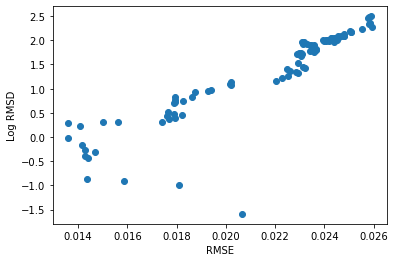

In [134]:
plt.scatter(df_full['rmse'], df_full['log_RMSD'])
plt.xlabel('RMSE')
plt.ylabel('Log RMSD')
plt.show()